In [17]:
# Import libraries for data processing, modeling, and evaluation
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

# Load price data (OHLCV) and sentiment scores from CSV files
price_data = pd.read_csv("DOGE_price_data.csv", parse_dates=["datetime"])

# Load sentiment data with emojis
sentiment_data_with = pd.read_csv("finbert_vader_sentiment_results.csv", parse_dates=["created_utc"])

# Load sentiment data without emojis
sentiment_data_without = pd.read_csv("finbert_vader_sentiment_results_wo_emoji.csv", parse_dates=["created_utc"])

In [18]:
# Merge price and sentiment data (with emojis)
merged_with = pd.merge_asof(
    price_data.sort_values("datetime"), # Ensure chronological order for price data
    sentiment_data_with.sort_values("created_utc"), # Ensure chronological order for sentiment
    left_on="datetime", # Price data timestamp column
    right_on="created_utc", # Sentiment timestamp column
    direction="nearest" # Match to closest available sentiment
)

# Merge price and sentiment data (without emojis)
merged_without = pd.merge_asof(
    price_data.sort_values("datetime"),
    sentiment_data_without.sort_values("created_utc"),
    left_on="datetime",
    right_on="created_utc",
    direction="nearest"
)

# Create target variable for both datasets: 1 if next hour's price increases, 0 otherwise
for merged, label in zip([merged_with, merged_without], ["with", "without"]):
    merged["next_close"] = merged["close"].shift(-1) # Get next hour's closing price
    merged["price_up"] = (merged["next_close"] > merged["close"]).astype(int) # Binary outcome
    merged.dropna(subset=["price_up"], inplace=True) # Remove rows with missing target


In [19]:
# Ensure vader_sentiment is numeric for both datasets
merged_with["vader_sentiment"] = pd.to_numeric(merged_with["vader_sentiment"], errors="coerce")
merged_without["vader_sentiment"] = pd.to_numeric(merged_without["vader_sentiment"], errors="coerce")

# Convert sentiment labels to numerical scores for finbert_sliding_sentiment in both datasets
sentiment_mapping = {"neutral": 0, "positive": 1, "negative": -1}
merged_with["finbert_sliding_sentiment"] = merged_with["finbert_sliding_sentiment"].map(sentiment_mapping)
merged_without["finbert_sliding_sentiment"] = merged_without["finbert_sliding_sentiment"].map(sentiment_mapping)

# Drop rows with invalid data in sentiment columns for both datasets
merged_with.dropna(subset=["vader_sentiment", "finbert_sliding_sentiment"], inplace=True)
merged_without.dropna(subset=["vader_sentiment", "finbert_sliding_sentiment"], inplace=True)

In [20]:
# Feature engineering for both datasets
for merged, label in zip([merged_with, merged_without], ["with", "without"]):
    # Create lagged sentiment features (1-6 hours) as effects take time
    for lag in [1, 2, 3, 4, 5, 6]:
        merged[f"vader_lag{lag}"] = merged["vader_sentiment"].shift(lag)
        merged[f"finbert_lag{lag}"] = merged["finbert_sliding_sentiment"].shift(lag)

    # Create market features
    merged["returns"] = merged["close"].pct_change()  # Hourly price returns
    merged["volatility"] = merged["returns"].rolling(6).std()  # 6-hour rolling volatility
    merged["volume_change"] = merged["volume"].pct_change()

    # Clean data by removing rows with missing values (just in case)
    merged.dropna(inplace=True)



In [21]:
# Define features and target for both datasets
features = [
    "returns", "volatility", "volume_change", # Market metrics
    "vader_lag1", "vader_lag2", "vader_lag3", # Vader sentiment (1-3 hour lags)
    "finbert_lag1", "finbert_lag2", "finbert_lag3" # FinBERT sentiment (1-3 hour lags)
]

X_with = merged_with[features] # Feature matrix
y_with = merged_with["price_up"] # Target vector

X_without = merged_without[features]
y_without = merged_without["price_up"]


In [22]:
# Train-test split for both datasets (time-series aware)
split_idx_with = int(0.8 * len(X_with))
X_train_with, X_test_with = X_with[:split_idx_with], X_with[split_idx_with:] # features split
y_train_with, y_test_with = y_with[:split_idx_with], y_with[split_idx_with:] # target split

split_idx_without = int(0.8 * len(X_without))
X_train_without, X_test_without = X_without[:split_idx_without], X_without[split_idx_without:]
y_train_without, y_test_without = y_without[:split_idx_without], y_without[split_idx_without:]

In [23]:
# Standardize features for both datasets
scaler_with = StandardScaler()
X_train_scaled_with = scaler_with.fit_transform(X_train_with)
X_test_scaled_with = scaler_with.transform(X_test_with)

scaler_without = StandardScaler()
X_train_scaled_without = scaler_without.fit_transform(X_train_without)
X_test_scaled_without = scaler_without.transform(X_test_without)

In [24]:
# Train logistic regression models for both datasets
model_with = LogisticRegression(max_iter=1000) # Increased iterations for convergence
model_with.fit(X_train_scaled_with, y_train_with) # Fit model to training data

model_without = LogisticRegression(max_iter=1000)
model_without.fit(X_train_scaled_without, y_train_without)

LogisticRegression(max_iter=1000)

In [25]:
# Evaluate models for both datasets
y_pred_with = model_with.predict(X_test_scaled_with) # Class predictions
y_proba_with = model_with.predict_proba(X_test_scaled_with)[:, 1] # Probability estimates

y_pred_without = model_without.predict(X_test_scaled_without) 
y_proba_without = model_without.predict_proba(X_test_scaled_without)[:, 1]

print(f"With Emojis - Accuracy: {accuracy_score(y_test_with, y_pred_with):.2f}") # Classification accuracy
print(f"With Emojis - AUC-ROC: {roc_auc_score(y_test_with, y_proba_with):.2f}") # Area under ROC curve

print(f"Without Emojis - Accuracy: {accuracy_score(y_test_without, y_pred_without):.2f}")
print(f"Without Emojis - AUC-ROC: {roc_auc_score(y_test_without, y_proba_without):.2f}")

# Feature importance comparison
coefs_with = pd.Series(model_with.coef_[0], index=features)
coefs_without = pd.Series(model_without.coef_[0], index=features)

print("Top Predictive Features (With Emojis):") 
print(coefs_with.abs().sort_values(ascending=False).head(5)) # Show top 5 impactful features

print("Top Predictive Features (Without Emojis):")
print(coefs_without.abs().sort_values(ascending=False).head(5))

With Emojis - Accuracy: 0.53
With Emojis - AUC-ROC: 0.54
Without Emojis - Accuracy: 0.54
Without Emojis - AUC-ROC: 0.56
Top Predictive Features (With Emojis):
volatility      0.323280
finbert_lag1    0.221989
finbert_lag3    0.220639
returns         0.197174
vader_lag2      0.134331
dtype: float64
Top Predictive Features (Without Emojis):
finbert_lag3    0.520498
finbert_lag2    0.433708
volatility      0.321554
returns         0.236893
finbert_lag1    0.149491
dtype: float64


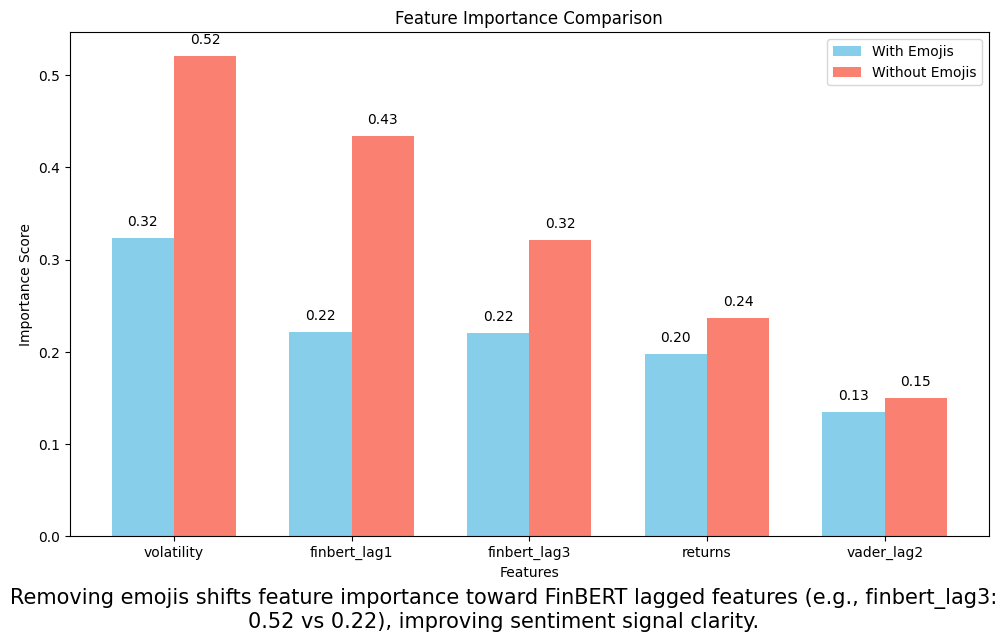

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Data for feature importance
features_with = ['volatility', 'finbert_lag1', 'finbert_lag3', 'returns', 'vader_lag2']
importance_with = [0.323280, 0.221989, 0.220639, 0.197174, 0.134331]
features_without = ['finbert_lag3', 'finbert_lag2', 'volatility', 'returns', 'finbert_lag1']
importance_without = [0.520498, 0.433708, 0.321554, 0.236893, 0.149491]

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart for feature importance comparison
x = np.arange(len(features_with))
width = 0.35

bars_with = ax.bar(x - width/2, importance_with, width=width, label='With Emojis', color='skyblue')
bars_without = ax.bar(x + width/2, importance_without, width=width, label='Without Emojis', color='salmon')

# Add value labels above bars
for bar in bars_with:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.2f}', ha='center', va='bottom', fontsize=10)
for bar in bars_without:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.2f}', ha='center', va='bottom', fontsize=10)

# Graph details
ax.set_xticks(x)
ax.set_xticklabels(features_with)
ax.set_xlabel('Features')
ax.set_ylabel('Importance Score')
ax.set_title('Feature Importance Comparison')
ax.legend()

# Add caption within the figure
fig.text(0.5, -0.05,
         "Removing emojis shifts feature importance toward FinBERT lagged features (e.g., finbert_lag3: 0.52 vs 0.22), improving sentiment signal clarity.",
         ha='center', fontsize=15, wrap=True)

plt.tight_layout()
plt.show()

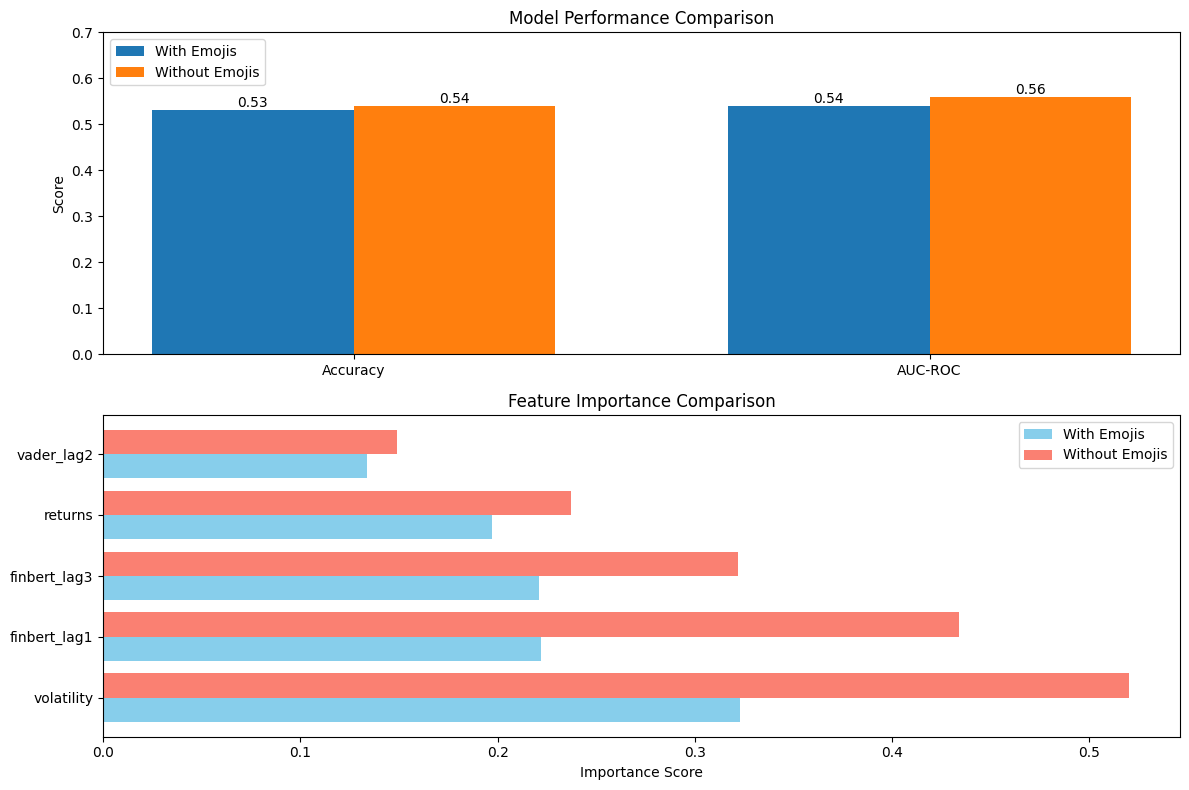

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ['Accuracy', 'AUC-ROC']
with_emojis = [0.53, 0.54]
without_emojis = [0.54, 0.56]

features_with = ['volatility', 'finbert_lag1', 'finbert_lag3', 'returns', 'vader_lag2']
importance_with = [0.323, 0.222, 0.221, 0.197, 0.134]

features_without = ['finbert_lag3', 'finbert_lag2', 'volatility', 'returns', 'finbert_lag1']
importance_without = [0.520, 0.434, 0.322, 0.237, 0.149]

# Create figure
plt.figure(figsize=(12, 8))

# Model performance comparison
plt.subplot(2, 1, 1)
x = np.arange(len(metrics))
width = 0.35
bars1 = plt.bar(x - width/2, with_emojis, width, label='With Emojis')
bars2 = plt.bar(x + width/2, without_emojis, width, label='Without Emojis')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.ylim(0, 0.7)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}', ha='center', va='bottom')

# Feature importance comparison
plt.subplot(2, 1, 2)
x = np.arange(len(features_with))
plt.barh(x - 0.2, importance_with, 0.4, label='With Emojis', color='skyblue')
plt.barh(x + 0.2, importance_without, 0.4, label='Without Emojis', color='salmon')
plt.yticks(x, features_with)
plt.xlabel('Importance Score')
plt.title('Feature Importance Comparison')
plt.legend()

plt.tight_layout()
plt.show()


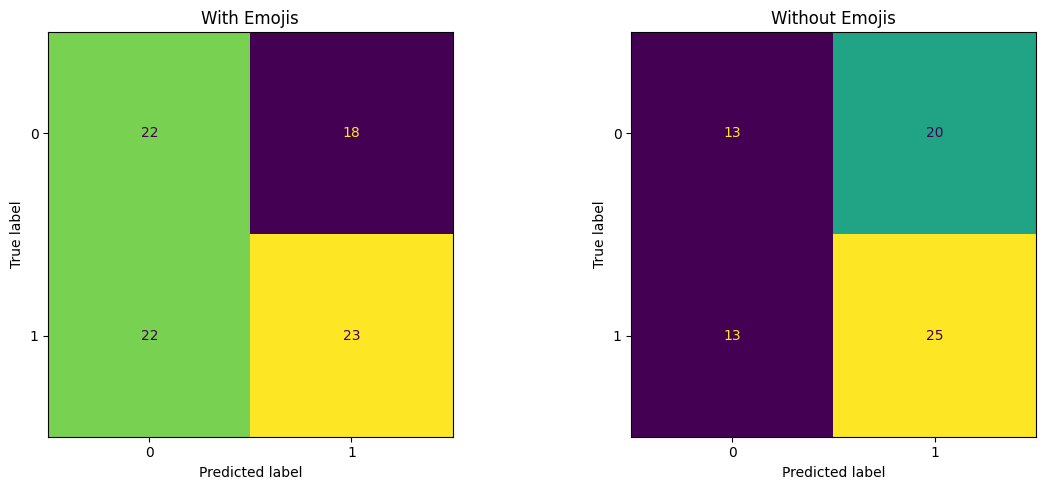

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# With emojis
cm_with = confusion_matrix(y_test_with, y_pred_with)
disp_with = ConfusionMatrixDisplay(confusion_matrix=cm_with)
disp_with.plot(ax=axes[0], values_format='d', colorbar=False)
axes[0].set_title('With Emojis')

# Without emojis
cm_without = confusion_matrix(y_test_without, y_pred_without)
disp_without = ConfusionMatrixDisplay(confusion_matrix=cm_without)
disp_without.plot(ax=axes[1], values_format='d', colorbar=False)
axes[1].set_title('Without Emojis')

plt.tight_layout()


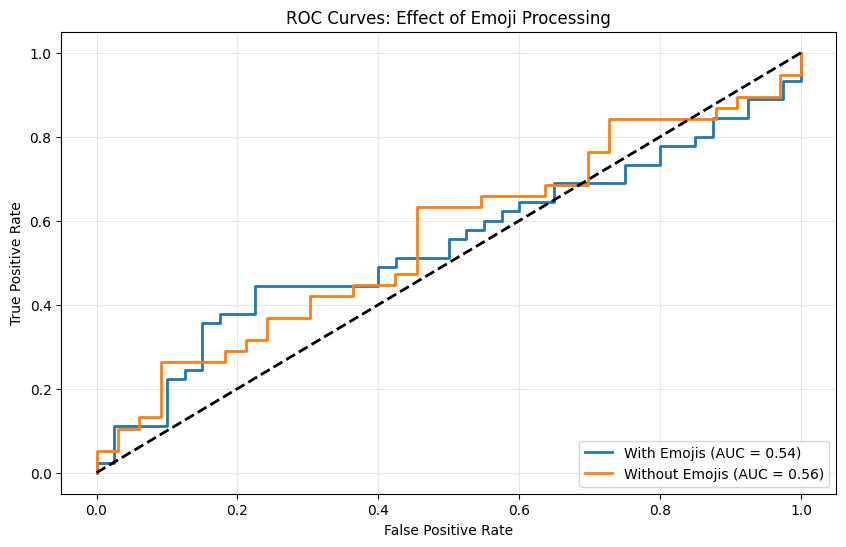

In [40]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 6))

# With emojis
fpr_with, tpr_with, _ = roc_curve(y_test_with, y_proba_with)
roc_auc_with = auc(fpr_with, tpr_with)
plt.plot(fpr_with, tpr_with, lw=2, 
         label=f'With Emojis (AUC = {roc_auc_with:.2f})')

# Without emojis
fpr_without, tpr_without, _ = roc_curve(y_test_without, y_proba_without)
roc_auc_without = auc(fpr_without, tpr_without)
plt.plot(fpr_without, tpr_without, lw=2, 
         label=f'Without Emojis (AUC = {roc_auc_without:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Effect of Emoji Processing')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)


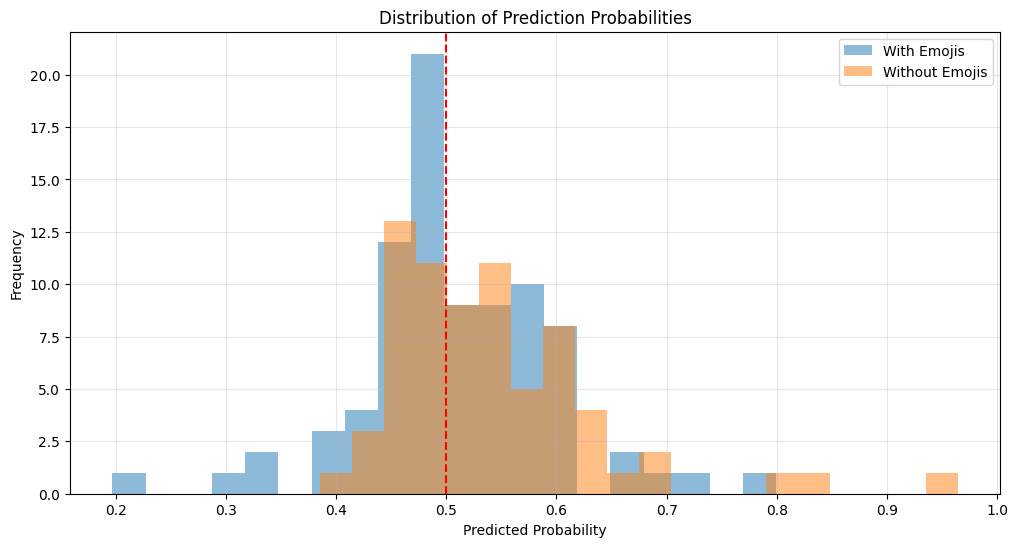

In [43]:
plt.figure(figsize=(12, 6))

plt.hist(y_proba_with, bins=20, alpha=0.5, label='With Emojis')
plt.hist(y_proba_without, bins=20, alpha=0.5, label='Without Emojis')
plt.axvline(0.5, color='red', linestyle='--')

plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Probabilities')
plt.legend()
plt.grid(True, alpha=0.3)


2023-04-17 14:00:00 2023-06-29 23:00:00
2023-04-17 10:00:00 2023-06-29 23:00:00


/var/folders/wv/9_zfl0j17p31nyfms_71vgn40000gn/T/ipykernel_68302/2736170811.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_with.fillna(method='ffill', inplace=True)
/var/folders/wv/9_zfl0j17p31nyfms_71vgn40000gn/T/ipykernel_68302/2736170811.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_without.fillna(method='ffill', inplace=True)


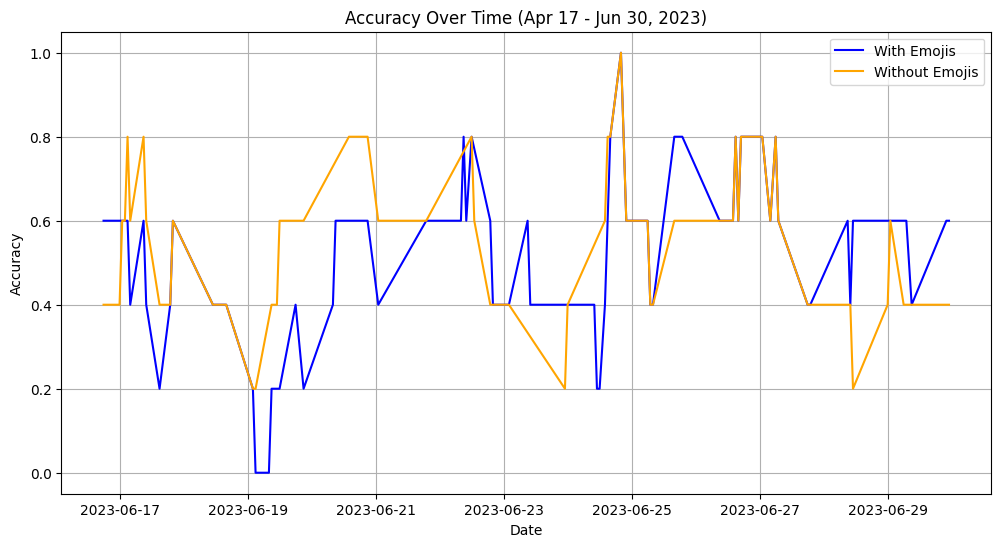

In [ ]:
print(merged_with['datetime'].min(), merged_with['datetime'].max())
print(merged_without['datetime'].min(), merged_without['datetime'].max())

# Use actual datetime column from merged datasets for test period
results_with = pd.DataFrame({
    'date': merged_with.iloc[split_idx_with:]['datetime'],  # Extract test set timestamps
    'actual': y_test_with.values,
    'predicted': y_pred_with
})

results_without = pd.DataFrame({
    'date': merged_without.iloc[split_idx_without:]['datetime'],
    'actual': y_test_without.values,
    'predicted': y_pred_without
})

# Calculate rolling accuracy for both datasets
window_size = 5  # Define rolling window size (e.g., 5 hours)
results_with['rolling_acc'] = results_with['actual'].eq(results_with['predicted']).rolling(window=window_size).mean()
results_without['rolling_acc'] = results_without['actual'].eq(results_without['predicted']).rolling(window=window_size).mean()

# Plot accuracy over time
plt.figure(figsize=(12, 6))
plt.plot(results_with['date'], results_with['rolling_acc'], label='With Emojis', color='blue')
plt.plot(results_without['date'], results_without['rolling_acc'], label='Without Emojis', color='orange')

plt.title('Accuracy Over Time (Apr 17 - Jun 30, 2023)')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
